In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [4]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

# Clustering of play data

In [6]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns).drop(['gameId', 'playId'], axis=1)

## K-Means

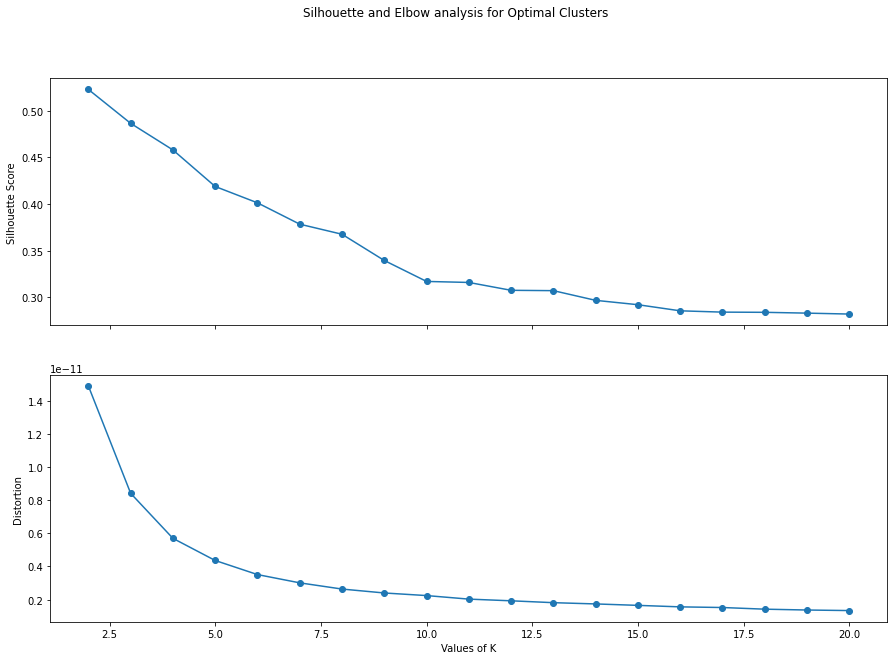

In [7]:
max_clusters = 20

range_clusters = []
for i in range(2, max_clusters + 1):
    range_clusters.append(i)

silhouette_avg = []
distortions = []

for i in range_clusters:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=1
    )
    km.fit(df_scaled)
    cluster_labels = km.labels_

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))
    distortions.append(km.inertia_)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(range_clusters, silhouette_avg, marker='o')
#axs[0].set_xlabel('Distance Threshold (x10e-6)')
axs[0].set_ylabel('Silhouette Score')
axs[1].plot(range_clusters, distortions, marker='o')
axs[1].set_xlabel('Values of K')
axs[1].set_ylabel('Distortion')
fig.suptitle('Silhouette and Elbow analysis for Optimal Clusters')
plt.show()

In [42]:
k = 8
km = KMeans(
    n_clusters=k, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=1
)

y_km = km.fit_predict(df_scaled)

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

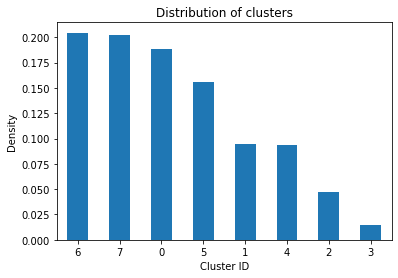

In [43]:
(df['clusters_kmeans'].value_counts()/df['clusters_kmeans'].value_counts().sum()).plot.bar(rot=0, title='Distribution of clusters', xlabel='Cluster ID', ylabel='Density')

## Agglomerative Clustering

### Silhouette testing on number of clusters

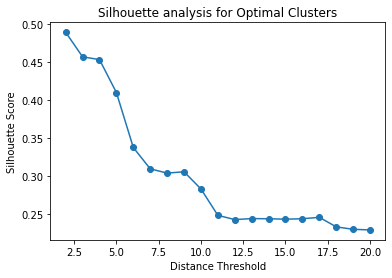

In [10]:
# Silhouette testing on n_clusters
range_clusters = []
n_samples = df_scaled.shape[0]
[range_clusters.append(x) for x in range(2, max_clusters + 1)]
silhouette_avg = []

for i in range_clusters:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=i)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_clusters, silhouette_avg, marker='o')
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
plt.show()

### Silhouette testing on distance threshold

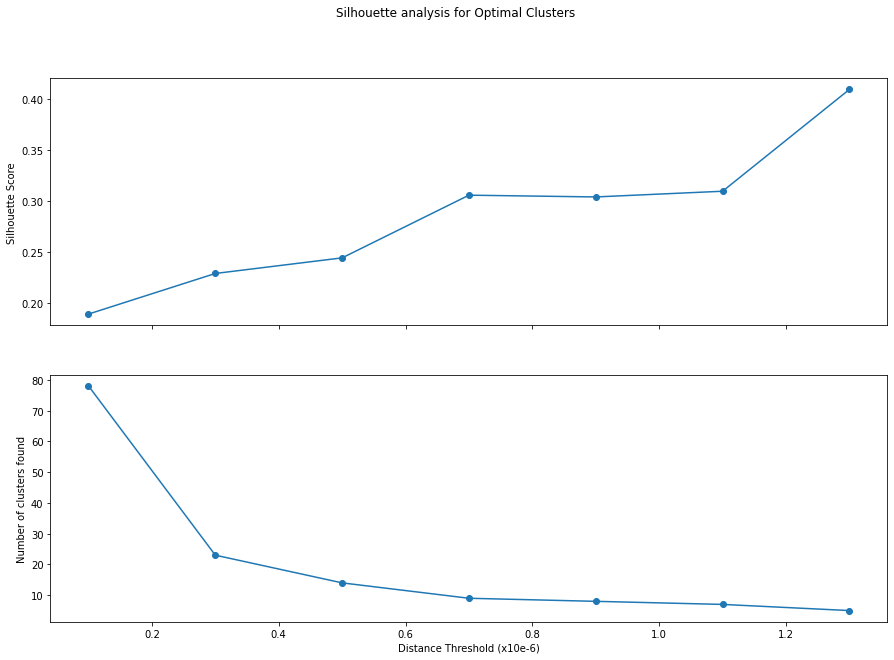

In [11]:
# Silhouette testing on limit
range_limit = [0.0000001, 0.0000003, 0.0000005, 0.0000007, 0.0000009, 0.0000011, 0.0000013]
n_samples = df_scaled.shape[0]

silhouette_avg = []
clusters_found = []

for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    clusters_found.append(np.unique(model.labels_).size)
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))

axs[0].plot(np.array(range_limit) * 10**6, silhouette_avg, marker='o')
#axs[0].set_xlabel('Distance Threshold (x10e-6)')
axs[0].set_ylabel('Silhouette Score')

axs[1].plot(np.array(range_limit) * 10**6, clusters_found, marker='o')
axs[1].set_xlabel('Distance Threshold (x10e-6)')
axs[1].set_ylabel('Number of clusters found')
fig.suptitle('Silhouette analysis for Optimal Clusters')

plt.show()

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

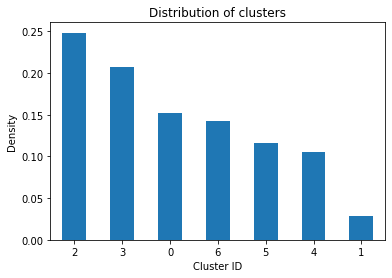

In [12]:
threshold = 1.1 * 10**-6
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=threshold,
                                n_clusters=None)
model.fit(df_scaled)

df['clusters_agg'] = model.labels_
(df['clusters_agg'].value_counts() / df['clusters_agg'].value_counts().sum()).plot.bar(rot=0,
                                                                                             title='Distribution of clusters',
                                                                                             xlabel='Cluster ID',
                                                                                             ylabel='Density')

## Random Forest

In [13]:
features = df[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']]
cols = ['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']
x_train, x_test, y_train, y_test = train_test_split(df[cols], df[['clusters_kmeans', 'clusters_agg']], test_size=0.6, shuffle=False, random_state=1)

In [14]:
y_train.shape

(2390, 2)

In [15]:
clf_k = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clf_k.fit(x_train, y_train['clusters_kmeans'])

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

In [16]:
clf_a = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clf_a.fit(x_train, y_train['clusters_agg'])

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

In [18]:
perm_imp_k = permutation_importance(clf_k, x_train, y_train['clusters_kmeans'])

In [19]:
perm_imp_a = permutation_importance(clf_a, x_train, y_train['clusters_agg'])

<BarContainer object of 27 artists>

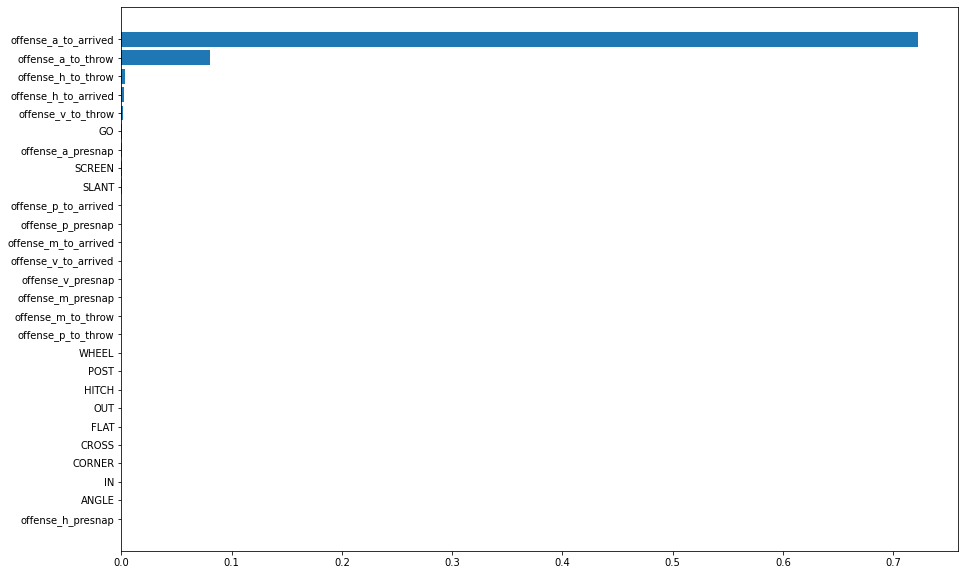

In [45]:
plt.figure(figsize=(15, 10))
sorted_idx_k = perm_imp_k.importances_mean.argsort()
plt.barh(clf_k.feature_names_in_[sorted_idx_k], perm_imp_k.importances_mean[sorted_idx_k])

<BarContainer object of 27 artists>

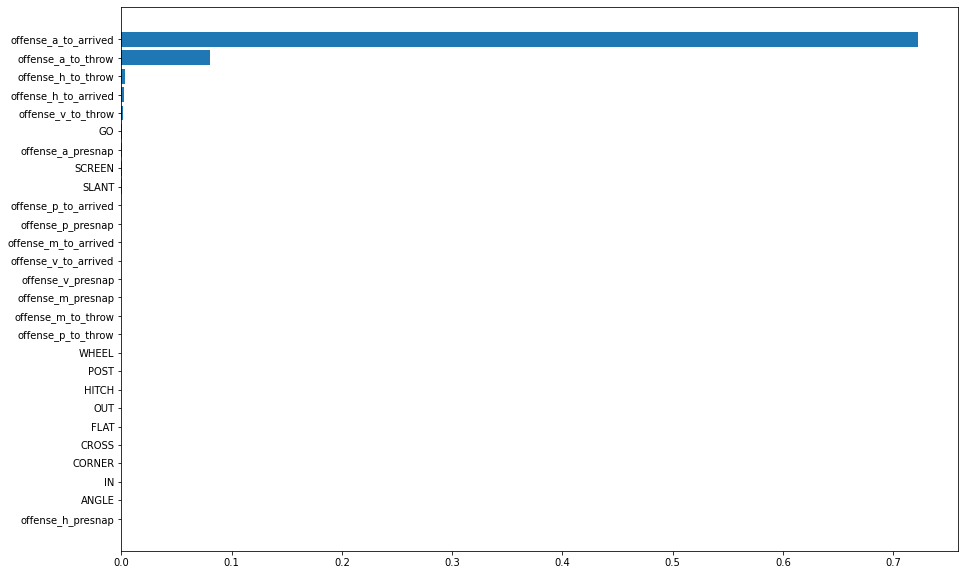

In [20]:
plt.figure(figsize=(15, 10))
sorted_idx_k = perm_imp_k.importances_mean.argsort()
plt.barh(clf_k.feature_names_in_[sorted_idx_k], perm_imp_k.importances_mean[sorted_idx_k])

In [21]:
#TODO: Accuracy scoring test

In [22]:
predicted = clf_k.predict(x_test)
print(
    f'Classification report for classifier {clf_k}:\n'
    f'{metrics.classification_report(y_test["clusters_kmeans"], predicted)}\n'
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       652
           1       1.00      0.94      0.97       325
           2       0.79      0.70      0.74       181
           3       1.00      0.27      0.43        55
           4       0.86      0.92      0.89       348
           5       0.93      0.96      0.94       566
           6       0.95      0.97      0.96       744
           7       0.96      0.97      0.97       715

    accuracy                           0.94      3586
   macro avg       0.93      0.84      0.86      3586
weighted avg       0.94      0.94      0.93      3586




Confusion Matrix:
[[638   1   0   0   0   0   0  13]
 [ 20 305   0   0   0   0   0   0]
 [  0   0 126   0  46   9   0   0]
 [  0   0  33  15   7   0   0   0]
 [  0   0   0   0 320  24   4   0]
 [  0   0   0   0   1 544  21   0]
 [  0   0   0   0   0  10 720  14]
 [ 12   0   0   0   0   0   9 694]]


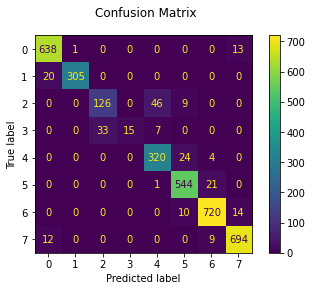

In [23]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test['clusters_kmeans'], predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [24]:
predicted = clf_a.predict(x_test)
print(
    f'Classification report for classifier {clf_a}:\n'
    f'{metrics.classification_report(y_test["clusters_agg"], predicted)}\n'
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       573
           1       1.00      0.98      0.99       111
           2       0.97      1.00      0.98       891
           3       0.99      1.00      0.99       728
           4       1.00      0.99      0.99       355
           5       0.99      0.94      0.97       431
           6       1.00      0.98      0.99       497

    accuracy                           0.99      3586
   macro avg       0.99      0.98      0.99      3586
weighted avg       0.99      0.99      0.99      3586




Confusion Matrix:
[[571   0   0   0   0   2   0]
 [  2 109   0   0   0   0   0]
 [  0   0 888   0   0   2   1]
 [  0   0   0 727   0   0   1]
 [  0   0   0   5 350   0   0]
 [  2   0  23   0   0 406   0]
 [  0   0   8   4   0   0 485]]


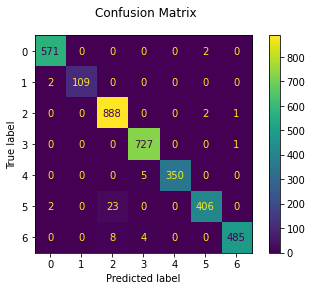

In [25]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test['clusters_agg'], predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

[4.9999999999999996e-06, 4.45e-06, 3.9e-06, 3.3499999999999997e-06, 2.8e-06, 2.25e-06, 1.6999999999999998e-06, 1.15e-06, 6.000000000000002e-07, 5e-08]


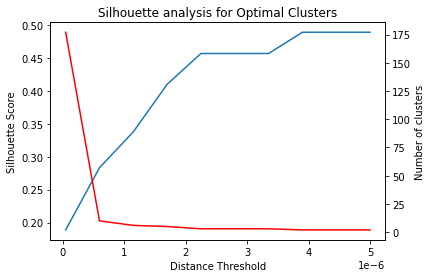

In [26]:
range_limit = []
[range_limit.append(n) for n in np.linspace(5*10**-6, 5*10**-8, 10)]
print(range_limit)
silhouette_avg = []
n_clusters = []
for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    n_clusters.append(len(np.unique(model.labels_)))

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_limit, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
ax2 = ax.twinx()
ax2.plot(range_limit, n_clusters, color='r')
ax2.set_ylabel('Number of clusters')
plt.show()

In [27]:
agglom_sizes = df.groupby('clusters_agg').size()
agglom_sizes

clusters_agg
0     908
1     173
2    1484
3    1235
4     628
5     697
6     851
dtype: int64

In [28]:
df.head()

,gameId,playId,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,...,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes,clusters_kmeans,clusters_agg
0,2018090600,75,-0.000000,4.733452,4.306341,0.491735,0.586294,0.488032,0.455213,0.265324,...,0,0,0,0,0,0,0,4,7,6
1,2018090600,146,0.722081,4.249899,3.185872,0.466888,0.413593,0.501455,0.352721,0.198450,...,0,0,0,0,0,0,0,5,0,3
3,2018090600,190,-0.000000,5.278721,4.789590,0.368274,0.272067,0.305495,0.325148,0.405869,...,0,0,1,1,0,0,0,3,7,6
4,2018090600,256,0.592412,3.949740,4.065981,0.521001,0.355874,0.586696,0.222165,0.272859,...,0,0,0,0,0,0,0,3,0,3
5,2018090600,320,0.856801,4.486656,4.609067,0.203906,0.588602,0.382720,0.103318,0.213341,...,0,0,0,0,1,0,0,5,0,3


In [46]:
df.groupby('clusters_agg')[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived']].mean().T

clusters_agg,0,1,2,3,4,5,6
offense_h_presnap,0.156833,0.129199,0.173288,0.241130,0.339980,0.168794,0.215734
offense_h_to_throw,5.046060,5.317265,4.797299,4.467054,3.774902,4.895292,4.683479
offense_h_to_arrived,4.141317,4.235123,3.984150,3.887228,3.682821,4.069392,3.918021
offense_p_presnap,0.441483,0.434026,0.433502,0.420340,0.398972,0.427857,0.434876
offense_p_to_throw,0.506308,0.482926,0.502748,0.487788,0.476034,0.508686,0.503711
offense_p_to_arrived,0.520093,0.566700,0.522700,0.487890,0.472612,0.524960,0.509242
offense_m_presnap,0.248219,0.252028,0.249262,0.261005,0.267142,0.252543,0.252213
offense_m_to_throw,0.313317,0.319366,0.298251,0.285357,0.276302,0.300965,0.297111
offense_m_to_arrived,0.312161,0.314512,0.320580,0.338173,0.328233,0.309896,0.324426
offense_v_presnap,0.030724,0.026535,0.032504,0.041117,0.059720,0.032469,0.039372


In [30]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

gameId,2018090600,2018090900,2018090901,2018090902,2018090903,2018090905,2018090906,2018090907,2018090909,2018090910,...,2018123006,2018123007,2018123008,2018123009,2018123010,2018123011,2018123012,2018123013,2018123014,2018123015
HITCH,0.953488,0.764706,0.500000,0.736842,0.629630,0.8750,0.470588,0.333333,1.000000,0.894737,...,0.8750,0.20,1.103448,0.809524,0.733333,0.785714,0.846154,0.529412,0.666667,0.565217
OUT,0.348837,0.294118,0.291667,0.526316,0.629630,0.3125,0.352941,0.523810,0.526316,0.421053,...,0.1250,0.55,0.655172,0.666667,0.533333,0.392857,0.423077,0.529412,0.541667,0.739130
FLAT,0.790698,0.764706,0.666667,0.526316,0.555556,0.6250,0.647059,0.666667,1.157895,0.473684,...,0.5625,0.50,0.724138,0.380952,0.633333,0.857143,0.730769,0.470588,0.666667,0.347826
CROSS,0.511628,0.235294,0.416667,0.263158,0.333333,0.1250,0.117647,0.476190,0.263158,0.578947,...,0.3125,0.70,0.241379,0.333333,0.533333,0.428571,0.807692,0.294118,0.500000,0.434783
GO,0.813953,0.941176,1.208333,0.736842,1.000000,1.2500,0.882353,0.857143,0.473684,0.578947,...,0.6875,0.80,0.896552,0.952381,0.633333,0.785714,0.500000,0.647059,0.833333,0.652174
SLANT,0.162791,0.352941,0.291667,0.210526,0.259259,0.5000,0.352941,0.285714,0.368421,0.315789,...,0.7500,0.30,0.413793,0.190476,0.100000,0.250000,0.269231,0.235294,0.250000,0.173913
SCREEN,0.069767,0.117647,0.583333,0.368421,0.185185,0.1875,0.294118,0.285714,0.263158,0.263158,...,0.2500,0.35,0.172414,0.523810,0.433333,0.178571,0.153846,0.176471,0.166667,0.260870
CORNER,0.139535,0.117647,0.125000,0.105263,0.074074,0.0625,0.235294,0.190476,0.368421,0.157895,...,0.2500,0.10,0.103448,0.000000,0.333333,0.214286,0.115385,0.411765,0.166667,0.086957
IN,0.441860,0.294118,0.250000,0.315789,0.481481,0.3125,0.411765,0.285714,0.210526,0.473684,...,0.1250,0.25,0.275862,0.476190,0.233333,0.285714,0.461538,0.529412,0.208333,0.434783
ANGLE,0.093023,0.176471,0.166667,0.263158,0.333333,0.1250,0.294118,0.142857,0.105263,0.210526,...,0.1250,0.20,0.068966,0.190476,0.200000,0.071429,0.038462,0.294118,0.125000,0.173913


<AxesSubplot:title={'center':'Average routes per play per game'}, ylabel='Number per play'>

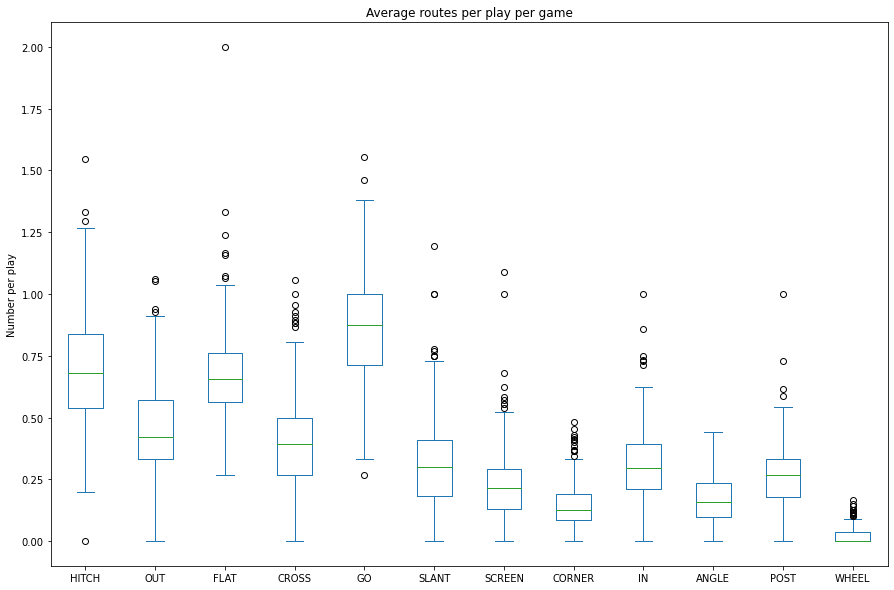

In [31]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per game')

<AxesSubplot:title={'center':'Average routes per play per cluster'}, ylabel='Number per play'>

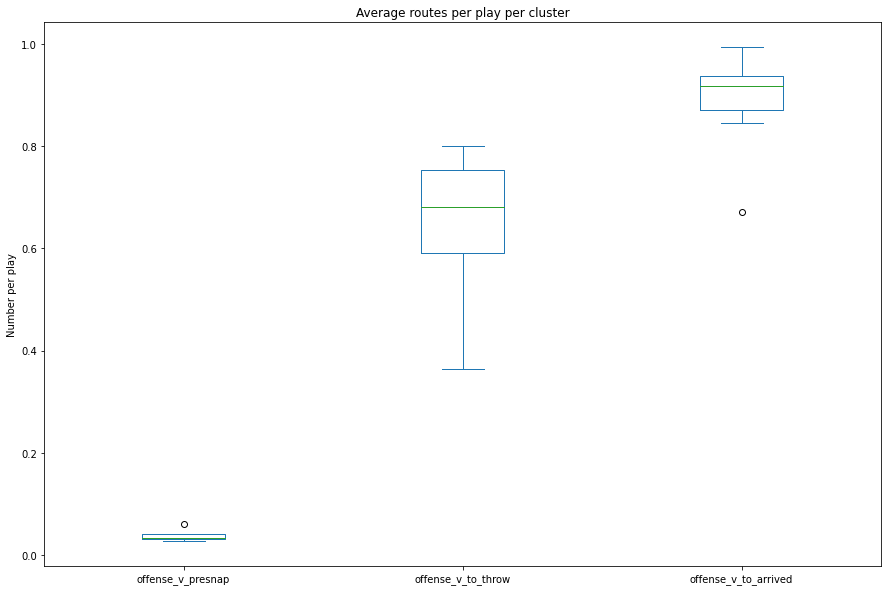

In [51]:
df.groupby('clusters_agg')[['offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per cluster')

<AxesSubplot:title={'center':'Average routes per play per cluster'}, ylabel='Number per play'>

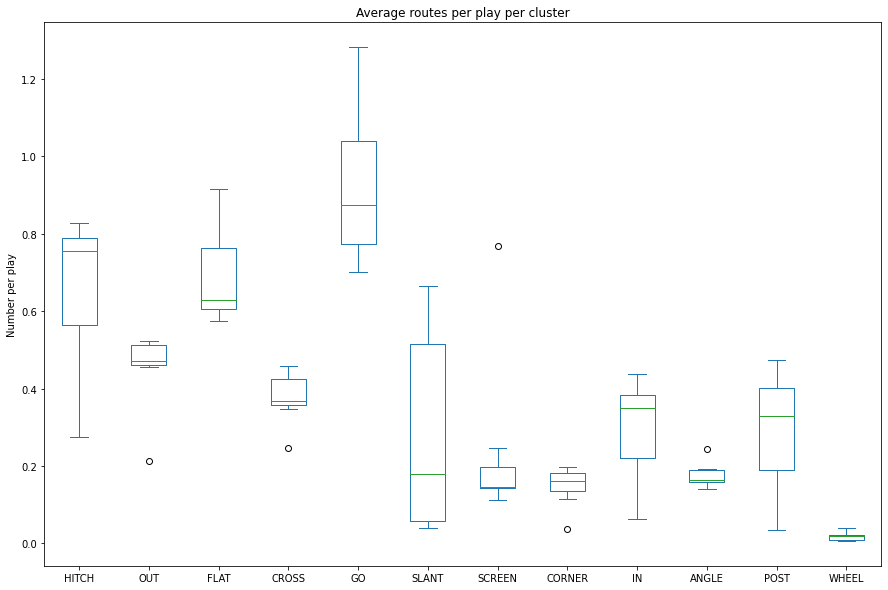

In [32]:
df.groupby('clusters_agg')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per cluster')

In [33]:
cluster0 = df.drop(['gameId', 'playId', 'clusters_agg'], axis=1).loc[(df['clusters_agg'] == 0)]
cluster0.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.15683
offense_h_to_throw        5.04606
offense_h_to_arrived      4.14132
offense_p_presnap         0.44148
offense_p_to_throw        0.50631
offense_p_to_arrived      0.52009
offense_m_presnap         0.24822
offense_m_to_throw        0.31332
offense_m_to_arrived      0.31216
offense_v_presnap         0.03072
offense_v_to_throw        0.77079
offense_v_to_arrived      0.92983
offense_a_presnap        72.49037
offense_a_to_throw      207.37815
offense_a_to_arrived    542.47701
HITCH                     0.75441
OUT                       0.50991
FLAT                      0.62885
CROSS                     0.39758
GO                        1.04626
SLANT                     0.04185
SCREEN                    0.11233
CORNER                    0.19824
IN                        0.35022
ANGLE                     0.18612
POST                      0.41189
WHEEL                     0.01322
num_routes                4.65088
clusters_kmeans           3.75220
dtype: object

In [34]:
cluster2 = df.drop(['gameId', 'playId', 'clusters_agg'], axis=1).loc[(df['clusters_agg'] == 2)]
cluster2.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.17329
offense_h_to_throw        4.79730
offense_h_to_arrived      3.98415
offense_p_presnap         0.43350
offense_p_to_throw        0.50275
offense_p_to_arrived      0.52270
offense_m_presnap         0.24926
offense_m_to_throw        0.29825
offense_m_to_arrived      0.32058
offense_v_presnap         0.03250
offense_v_to_throw        0.68201
offense_v_to_arrived      0.91906
offense_a_presnap        69.31698
offense_a_to_throw      151.61658
offense_a_to_arrived    361.24002
HITCH                     0.82884
OUT                       0.47102
FLAT                      0.60984
CROSS                     0.45350
GO                        0.87399
SLANT                     0.17857
SCREEN                    0.14555
CORNER                    0.16240
IN                        0.43666
ANGLE                     0.16375
POST                      0.32817
WHEEL                     0.01887
num_routes                4.67116
clusters_kmeans           6.06132
dtype: object

In [35]:
cluster0.columns

Index(['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes', 'clusters_kmeans'],
      dtype='object')

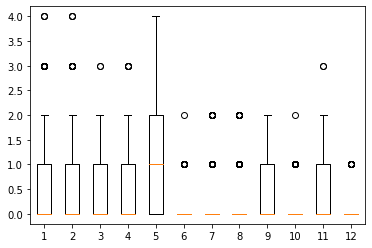

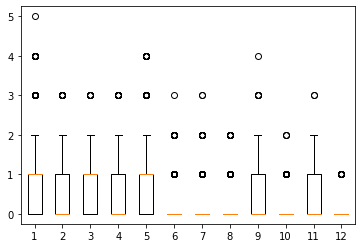

In [36]:
plt.boxplot(cluster0[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()
plt.boxplot(cluster2[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()

In [37]:
verticals = df.loc[(df['GO'] == 4)]
sorted(verticals['clusters_agg'].unique().tolist())

[0, 1, 2, 3, 4, 5, 6]

In [38]:
flood = df.loc[(df['CORNER'] == 1) & (df['OUT'] == 1) & (df['FLAT'] == 1) & (df['POST'] == 1)]
sorted(flood['clusters_agg'].unique().tolist())

[0, 2, 3, 5, 6]

In [39]:
slants = df.loc[(df['SLANT'] >= 2)]
sorted(slants['clusters_agg'].unique().tolist())

[0, 2, 3, 4, 5, 6]

In [40]:
def plot_relationship(df, xcol, ycol, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    main_ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        left=True,
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    x = df[xcol]
    y = df[ycol]
    main_ax.scatter(x, y, c=labels)

    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
    x_hist.invert_yaxis()
    x_hist.set_xlabel(xcol)

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    y_hist.invert_xaxis()
    y_hist.set_ylabel(ycol)

In [41]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
plot_relationship(df, df_columns[0], df_columns[1], model.labels_)

KeyError: "['cluster'] not found in axis"

In [ ]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], model.labels_)

In [ ]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_a_presnap']
y = df_scaled['offense_a_to_throw']
z = df_scaled['offense_a_to_arrived']
ax.scatter3D(x, y, z, c=model.labels_)